# Model 2: Dynamic  Revenue  Maximization

This  model  builds  on  the  baseline  by 
introducing a multi-round time horizon to assess long-term planning, changing the objective to 
maximizing total revenue. It adds dynamic elements to simulate market changes, such as a 
constant growth in demand. This creates a dynamic financial situation where revenue streams 
must be managed to fund investments, forcing players to plan around an evolving budget rather 
than a static one

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations
7) Dual Analysis

### Imports

In [1]:
import json
from pathlib import Path
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

### Load input data

In [2]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:20]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

# load co2 intensity for technologies
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "CO2 intensity": 0
}
costs = costs.value.unstack().fillna(defaults)

co2_intensity = {
    #"Gas turbine (simple cycle)": costs.at["gas", "CO2 intensity"],
    #"Natural gas engine plant":   costs.at["gas", "CO2 intensity"],
    "Diesel engine farm":         costs.at["gas", "CO2 intensity"]*1.2,
    "OCGT - Natural gas":         costs.at["gas", "CO2 intensity"],
    "Coal power plant":           costs.at["coal", "CO2 intensity"],
    "Nuclear power plant":        costs.at["nuclear", "CO2 intensity"],
    "Onshore wind":               costs.at["onwind", "CO2 intensity"],
    "Offshore wind (fixed)":      costs.at["offwind", "CO2 intensity"],
    "Utility-scale PV":           costs.at["solar-utility", "CO2 intensity"],
}

df_co2 = pd.DataFrame.from_dict(co2_intensity, orient="index", columns=["CO2 intensity (tCO2/MWh)"]).T
print("CO2 Intensity by Technology:")
display(df_co2)

net_capacity = pd.read_csv(Path("data") / "net_installed_capacity.csv")
# Drop the first (metadata) row, reset index, convert capacity columns to numeric and compute total (MW)
net_capacity = net_capacity.iloc[1:].reset_index(drop=True)

# Convert all columns except 'Year' to numeric (they are GW in the source)
num_cols = [c for c in net_capacity.columns if c != "Year"]
net_capacity[num_cols] = net_capacity[num_cols].apply(pd.to_numeric, errors="coerce")

# Sum capacities (assume values are in GW) and convert to MW
sum_capacity_gw = net_capacity[num_cols].sum().sum()
sum_capacity = sum_capacity_gw * 1e3  # MW

print("Net installed capacity (cleaned):")
display(net_capacity)
print(f"Total installed capacity in dataset: {sum_capacity:.2f} MW")

Technology Data:


,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


CO2 Intensity by Technology:


,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
CO2 intensity (tCO2/MWh),0.2376,0.198,0.3361,0.0,0.0,0.0,0.0


Net installed capacity (cleaned):


,Year,Hydro Run-of-River,Biomass,Fossil hard coal,Fossil oil,Fossil gas,Other renewables,Waste,Wind offshore,Wind onshore,Solar AC
0,2025.0,0.01,1.75,3.02,0.96,1.57,0.14,0.38,2.65,4.86,3.73


Total installed capacity in dataset: 19070.00 MW


### Scenario Parameters

In [3]:
market_share = 0.35                               
num_periods = 20
time_periods = list(range(num_periods))
hours_per_year = 8760

initial_budget = 100                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

net_revenue_factor = 0.7

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    #"Gas turbine (simple cycle)": market_share*1500,
    #"Natural gas engine plant":   market_share*1500,
    "Diesel engine farm":         market_share*sum_capacity*0.2,
    "OCGT - Natural gas":         market_share*sum_capacity*0.2,
    "Coal power plant":           market_share*sum_capacity*0.2,
    "Nuclear power plant":        market_share*sum_capacity*0.2,
    "Onshore wind":               market_share*sum_capacity*0.2,
    "Offshore wind (fixed)":      market_share*sum_capacity*0.2,
    "Utility-scale PV":           market_share*sum_capacity*0.2,
}

#### Preprocessing - build parameter dictionaries

In [4]:
tech_names = list(TECHNOLOGY_DATA.keys())

# --- Technical & economic parameters ---
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

# --- Prices ---
price_eur = {t: price_list[t]*net_revenue_factor for t in time_periods}
price_meur = {t: price_eur[t] / 1e6 for t in time_periods}

# --- Demand curve ---
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

### Gurobi Model Setup

#### Variables

In [5]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t
energy = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period [MEUR]
budget = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Auxiliary variables for accounting
revenue = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# O&M and CAPEX costs
op_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

Set parameter Username
Set parameter LicenseID to value 2626572
Academic license - for non-commercial use only - expires 2026-02-22


#### Model constraints

In [6]:
# Capacity accumulation
for tech in tech_names:
    model.addConstr(capacity[tech, 0] == investment[tech, 0])
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] == capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# Cumulative capacity limits
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# Production limited by capacity * efficiency * hours
for tech in tech_names:
    for t in time_periods:
        model.addConstr(
            energy[tech, t] <= capacity[tech, t] * elec_eff[tech] * hours_per_year,
            name=f"ProdCap_{tech}_{t}"
        )

# Define revenue, OPEX, CAPEX, fixed O&M
for t in time_periods:
    model.addConstr(
        revenue[t] == gp.quicksum(energy[tech, t] * price_meur[t] for tech in tech_names),
        name=f"RevenueDef_{t}"
    )

    model.addConstr(
        op_cost[t] == gp.quicksum(energy[tech, t] * vom_meur[tech] for tech in tech_names),
        name=f"OpCostDef_{t}"
    )

    model.addConstr(
        capex_cost[t] == gp.quicksum(investment[tech, t] * capex[tech] for tech in tech_names),
        name=f"CapexCostDef_{t}"
    )

    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(capacity[tech, t] * fixed_om_meur[tech] for tech in tech_names),
        name=f"FixedOMDef_{t}"
    )

# Budget dynamics
model.addConstr(budget[0] == initial_budget)

for t in time_periods:
    # Cannot invest more than available budget
    model.addConstr(capex_cost[t] <= budget[t], name=f"InvLimit_{t}")
    model.addConstr(budget[t] >= 0, name=f"BudgetNonNeg_{t}")

    if t < num_periods - 1:
        model.addConstr(
            budget[t+1] == budget[t] - capex_cost[t] + revenue[t] - op_cost[t] - fixed_om_cost[t],
            name=f"BudgetDyn_{t}"
        )

# Demand cap
for t in time_periods:
    model.addConstr(
        gp.quicksum(energy[tech, t] for tech in tech_names) <= demand[t],
        name=f"DemandCap_{t}"
    )

#### Objective Function + optimize

In [7]:
model.setObjective(
    gp.quicksum(
        revenue[t] - op_cost[t] - fixed_om_cost[t] - capex_cost[t]
        for t in time_periods
    ),
    GRB.MAXIMIZE
)
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 580 rows, 520 columns and 1728 nonzeros
Model fingerprint: 0xf4d6439b
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+07]
Presolve removed 386 rows and 207 columns
Presolve time: 0.05s
Presolved: 194 rows, 313 columns, 1620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1931053e+04   2.492218e+06   0.000000e+00      0s
     539    4.6822785e+03   0.000000e+00   0.000000e+00      0s

Solved in 539 iterations and 0.08 seconds (0.01 work units)
Optimal objective  4.682278476e+03


#### Results

In [8]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("Optimal solution found.\n")

    budget_df = pd.DataFrame({
        t: [budget[t].X]
        for t in time_periods
    }, index=["Budget (MEUR)"])

    print("---- Budget Evolution (MEUR) ----")
    display(budget_df)
    print()

    rev_cost_df = pd.DataFrame({
        t: {
            "Revenue (MEUR)":     revenue[t].X,
            "Var OPEX (MEUR)":    op_cost[t].X,
            "Fixed OPEX (MEUR)":  fixed_om_cost[t].X,
            "CAPEX (MEUR)":       capex_cost[t].X,
            "Net Cash Flow":      revenue[t].X - op_cost[t].X - capex_cost[t].X - fixed_om_cost[t].X
        }
        for t in time_periods
    })

    print("---- Revenue & Costs per Period (MEUR) ----")
    display(rev_cost_df)
    print()

    capacity_df = pd.DataFrame({
        t: {tech: capacity[tech, t].X for tech in tech_names}
        for t in time_periods
    })

    capacity_df.index.name = "Technology"

    capacity_df.loc["Total"] = capacity_df.sum(axis=0)

    print("---- Installed Capacity (MW) ----")
    display(capacity_df)
    print()

    production_df = pd.DataFrame({
        t: {tech: energy[tech, t].X/1e3 for tech in tech_names}
        for t in time_periods
    })

    production_df.index.name = "Technology"
    production_df.loc["Total"] = production_df.sum(axis=0)

    print("---- Energy Production (GWh) ----")
    display(production_df)
    print()

    totals_df = pd.DataFrame({
        "Total Revenue":      [sum(revenue[t].X for t in time_periods)],
        "Total Variable OPEX":[sum(op_cost[t].X for t in time_periods)],
        "Total Fixed OPEX":   [sum(fixed_om_cost[t].X for t in time_periods)],
        "Total CAPEX":        [sum(capex_cost[t].X for t in time_periods)],
        "Final Budget":       [budget[num_periods-1].X]
    })

    print("---- TOTALS OVER ALL PERIODS ----")
    display(totals_df)

Optimal solution found.

---- Budget Evolution (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Budget (MEUR),100.0,46.08257,65.188398,88.515704,124.260198,169.98051,231.413914,294.531539,348.815594,379.741367,417.621008,429.336378,484.409876,574.561272,1129.572855,1696.332646,2276.807688,2873.167232,3487.782734,4123.227859



---- Revenue & Costs per Period (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Revenue (MEUR),54.011584,76.771305,105.267409,148.030325,203.603245,275.659380,351.302841,421.179427,460.825590,505.746672,523.513189,584.807585,652.016891,662.000260,673.748467,687.463718,703.348220,721.604179,742.433801,766.039293
Var OPEX (MEUR),5.433633,7.937591,11.479690,16.289309,23.041152,30.265271,38.735889,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390,49.077390
Fixed OPEX (MEUR),2.495381,3.645316,5.272015,7.480818,10.581583,13.980194,18.035413,23.286443,32.006833,39.048274,45.099421,51.320319,57.911286,57.911286,57.911286,57.911286,57.911286,57.911286,57.911286,57.911286
CAPEX (MEUR),100.000000,46.082570,65.188398,88.515704,124.260198,169.980510,231.413914,294.531539,348.815594,379.741367,417.621008,429.336378,454.876820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Cash Flow,-53.917430,19.105828,23.327306,35.744494,45.720312,61.433404,63.117625,54.284055,30.925773,37.879640,11.715370,55.073498,90.151395,555.011584,566.759791,580.475042,596.359544,614.615503,635.445125,659.050617



---- Installed Capacity (MW) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,277.777778,405.784916,586.863799,832.740756,1177.907973,1334.900000,1334.900000,1334.9000,1334.900000,1334.900000,1334.900000,1334.900000,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9
OCGT - Natural gas,0.000000,0.000000,0.000000,0.000000,0.000000,241.411447,733.781478,1334.9000,1334.900000,1334.900000,1334.900000,1334.900000,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,202.870256,566.018959,939.354939,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Utility-scale PV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.5943,949.530073,1334.900000,1334.900000,1334.900000,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9,1334.9
Total,277.777778,405.784916,586.863799,832.740756,1177.907973,1576.311447,2068.681478,2701.3943,3619.330073,4207.570256,4570.718959,4944.054939,5339.6,5339.6,5339.6,5339.6,5339.6,5339.6,5339.6,5339.6



---- Energy Production (GWh) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Diesel engine farm,851.666667,1244.136551,1799.324408,2553.183158,3611.465845,4092.803400,4092.803400,4092.80340,4092.80340,4092.803400,4092.803400,4092.80340,4092.80340,4092.80340,4092.80340,4092.80340,4092.80340,4092.80340,4092.80340,4092.80340
OCGT - Natural gas,0.000000,0.000000,0.000000,0.000000,0.000000,867.053354,2635.449556,4794.42684,4794.42684,4794.426840,4794.426840,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684
Coal power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Nuclear power plant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Onshore wind,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,728.628813,2032.913692,3373.78720,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684,4794.42684
Offshore wind (fixed),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Utility-scale PV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.28257,1330.86135,1870.995840,1870.995840,1870.99584,1870.99584,1870.99584,1870.99584,1870.99584,1870.99584,1870.99584,1870.99584,1870.99584
Total,851.666667,1244.136551,1799.324408,2553.183158,3611.465845,4959.856754,6728.252956,8931.51281,10218.09159,11486.854893,12791.139772,14132.01328,15552.65292,15552.65292,15552.65292,15552.65292,15552.65292,15552.65292,15552.65292,15552.65292



---- TOTALS OVER ALL PERIODS ----


,Total Revenue,Total Variable OPEX,Total Fixed OPEX,Total CAPEX,Final Budget
0,9319.373381,771.188609,715.542297,3150.364,4123.227859


#### Visualizations

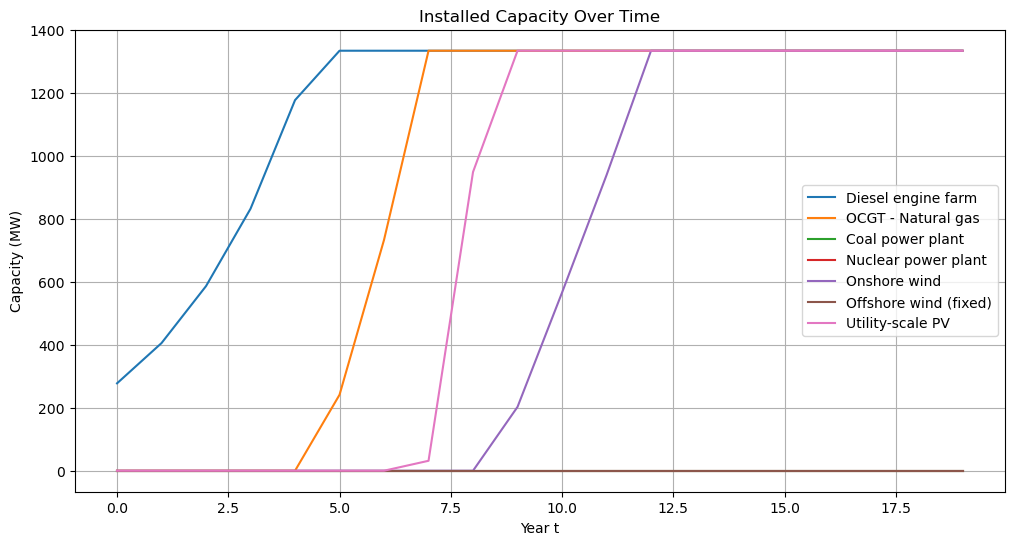

In [9]:
import matplotlib.pyplot as plt

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in cap_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.ylabel("Capacity (MW)")
plt.legend()
plt.grid(True)
plt.show()

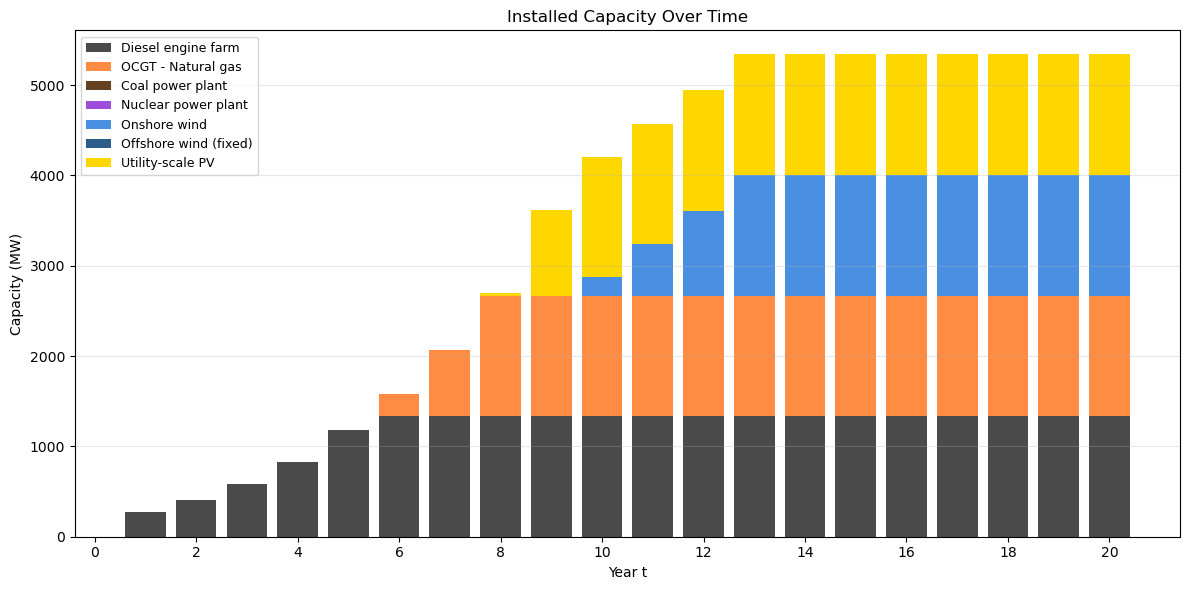

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

# Define intuitive colors for each technology
tech_colors = {
    'Gas turbine (simple cycle)': '#FF6B9D',      # Orange (gas)
    'Natural gas engine plant': '#E63946',        # Red (gas)
    'Diesel engine farm': '#4A4A4A',              # Dark gray (diesel/oil)
    'OCGT - Natural gas': '#FF8C42',              # Pink (gas)
    'Coal power plant': '#654321',                # Brown (coal)
    'Nuclear power plant': '#9D4EDD',             # Purple (nuclear)
    'Onshore wind': '#4A90E2',                    # Blue (wind)
    'Offshore wind (fixed)': '#2E5C8A',           # Dark blue (wind)
    'Utility-scale PV': '#FFD700',                # Yellow/gold (solar)
}

plt.figure(figsize=(12,6))
display_periods = [t + 1 for t in time_periods]

# Prepare data for stacking
bottom = np.zeros(len(time_periods))

for tech, vals in cap_plot.items():
    color = tech_colors.get(tech, '#CCCCCC')  # Default gray if not found
    plt.bar(display_periods, vals, label=tech, bottom=bottom, color=color)
    bottom += np.array(vals)  # Stack next bars on top

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.xticks(range(0, 21, 2))
plt.ylabel("Capacity (MW)")
plt.legend(fontsize=9)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

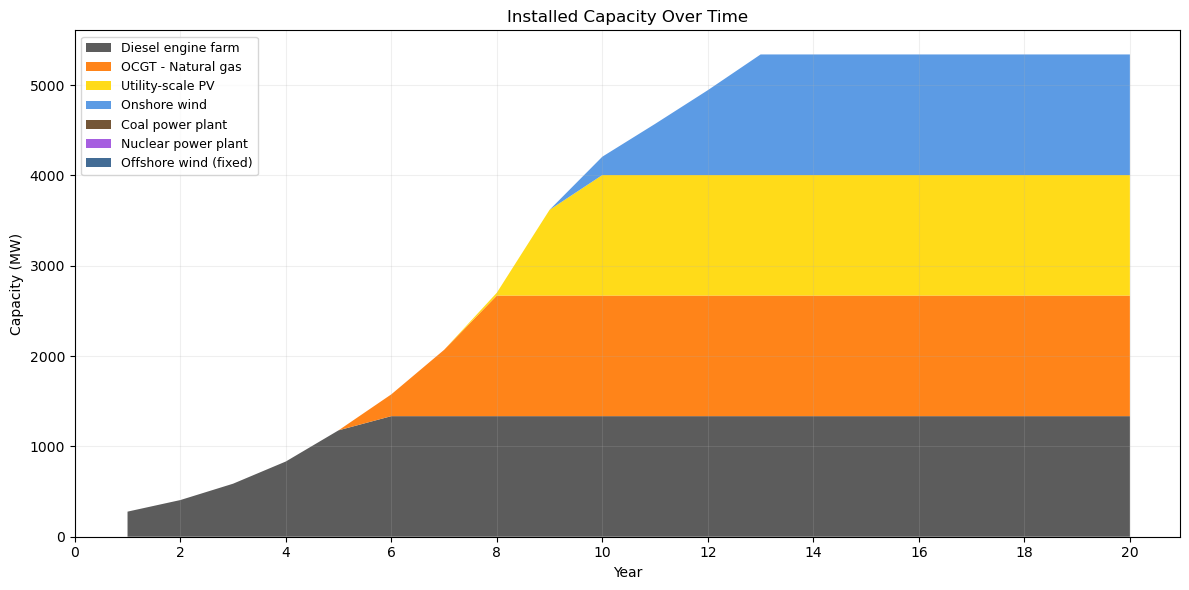

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

# Define intuitive colors for each technology
tech_colors = {
    'Gas turbine (simple cycle)': "#E877FF",      # Orange (gas)
    'Natural gas engine plant': '#E63946',        # Red (gas)
    'Diesel engine farm': '#4A4A4A',              # Dark gray (diesel/oil)
    'OCGT - Natural gas': "#FF7700",              # Pink (gas)
    'Coal power plant': '#654321',                # Brown (coal)
    'Nuclear power plant': '#9D4EDD',             # Purple (nuclear)
    'Onshore wind': '#4A90E2',                    # Blue (wind)
    'Offshore wind (fixed)': '#2E5C8A',           # Dark blue (wind)
    'Utility-scale PV': '#FFD700',                # Yellow/gold (solar)
}

plt.figure(figsize=(12,6))

display_periods = [t + 1 for t in time_periods]


# Sort technologies by when they first get capacity
def first_nonzero_period(tech):
    for i, val in enumerate(cap_plot[tech]):
        if val > 0:
            return time_periods[i]
    return float('inf')  # If never has capacity, put at end

tech_list = sorted(cap_plot.keys(), key=first_nonzero_period)
values = [cap_plot[tech] for tech in tech_list]
colors = [tech_colors.get(tech, '#CCCCCC') for tech in tech_list]

# Create stacked area plot
plt.stackplot(display_periods, values, labels=tech_list, colors=colors, alpha=0.9)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year")
plt.xticks(range(0, 21, 2))
plt.ylabel("Capacity (MW)")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

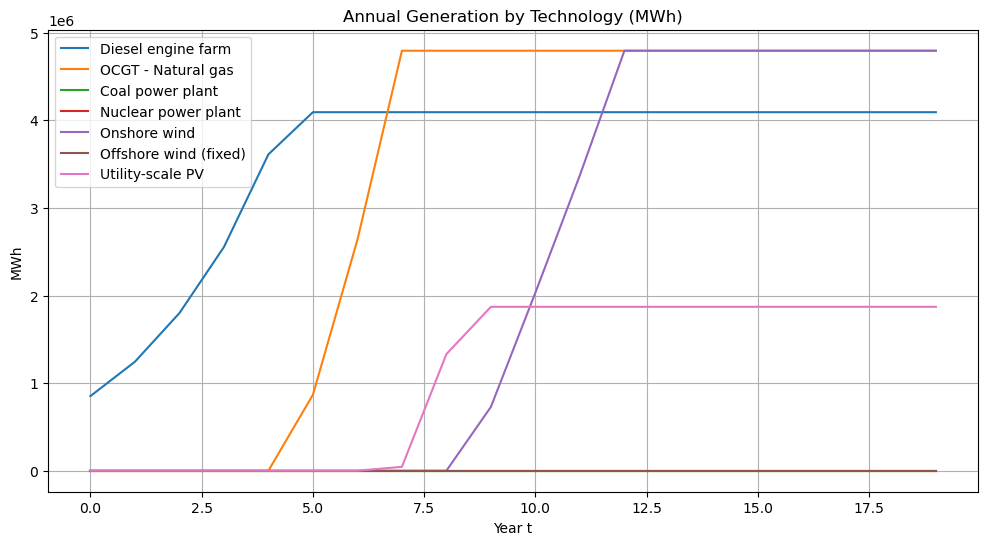

In [ ]:
gen_plot = {tech: [energy[tech,t].X for t in time_periods]
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in gen_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Annual Generation by Technology (MWh)")
plt.xlabel("Year t")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)
plt.show()

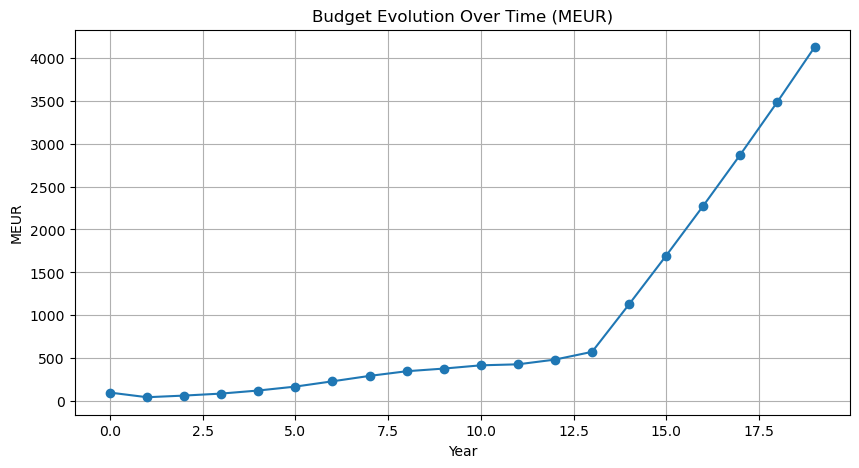

In [ ]:
bud = [budget[t].X for t in time_periods]

plt.figure(figsize=(10,5))
plt.plot(time_periods, bud, marker="o")
plt.title("Budget Evolution Over Time (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.grid(True)
plt.show()

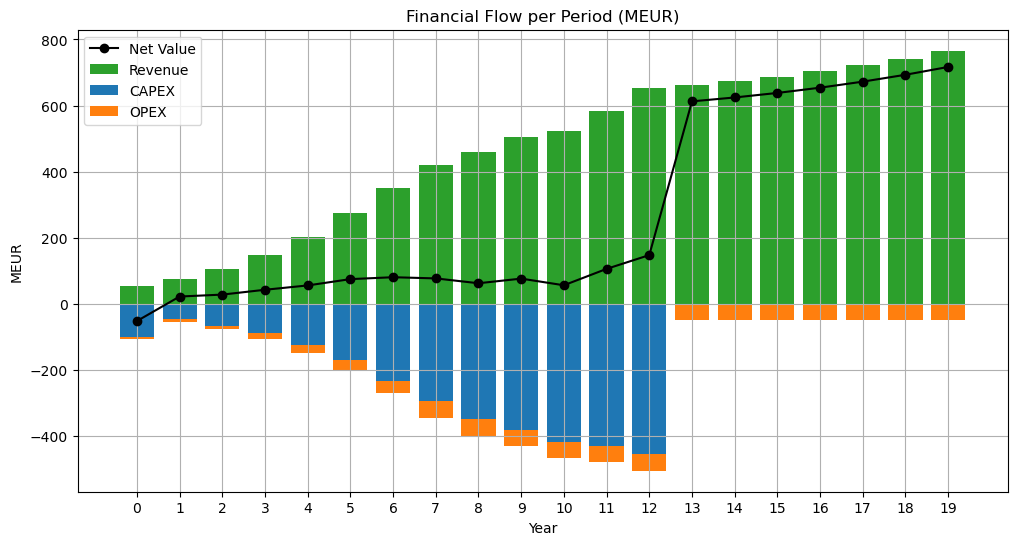

In [ ]:
import numpy as np

rev = [revenue[t].X for t in time_periods]
op  = [op_cost[t].X for t in time_periods]
cap = [capex_cost[t].X for t in time_periods]
net = [rev[i] - op[i] - cap[i] for i in range(len(time_periods))]

x = np.arange(len(time_periods))

plt.figure(figsize=(12,6))
plt.bar(x, rev, label="Revenue", color='tab:green')
plt.bar(x, [-o for o in cap], label="CAPEX", color='tab:blue')
plt.bar(x, [-c for c in op], bottom=[-o for o in cap], label="OPEX", color='tab:orange')

# Add net value line
plt.plot(x, net, label="Net Value", color='black', marker='o', linewidth=1.5, markersize=6)

plt.xticks(x, time_periods)
plt.title("Financial Flow per Period (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.legend()
plt.grid(True)
plt.show()

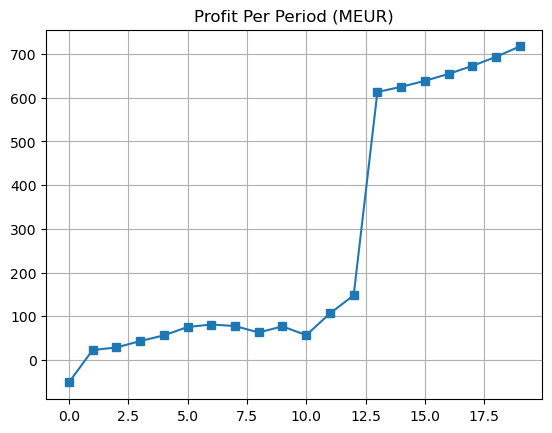

In [ ]:
profit_t = [revenue[t].X - op_cost[t].X - capex_cost[t].X 
            for t in time_periods]

plt.plot(time_periods, profit_t, marker="s")
plt.title("Profit Per Period (MEUR)")
plt.grid(True)
plt.show()

#### Model Duals

In [ ]:
for t in time_periods:
    constr = model.getConstrByName(f"DemandCap_{t}")
    print(f"Dual Demand Cap t={t}: {constr.Pi:.4f}")

Dual Demand Cap t=0: 0.0000
Dual Demand Cap t=1: 0.0000
Dual Demand Cap t=2: 0.0000
Dual Demand Cap t=3: 0.0000
Dual Demand Cap t=4: 0.0000
Dual Demand Cap t=5: 0.0000
Dual Demand Cap t=6: 0.0000
Dual Demand Cap t=7: 0.0000
Dual Demand Cap t=8: 0.0000
Dual Demand Cap t=9: 0.0000
Dual Demand Cap t=10: 0.0000
Dual Demand Cap t=11: 0.0000
Dual Demand Cap t=12: 0.0000
Dual Demand Cap t=13: 0.0000
Dual Demand Cap t=14: 0.0000
Dual Demand Cap t=15: 0.0000
Dual Demand Cap t=16: 0.0000
Dual Demand Cap t=17: 0.0000
Dual Demand Cap t=18: 0.0000
Dual Demand Cap t=19: 0.0000


In [ ]:
for tech in tech_names:
    for t in time_periods:
        c = model.getConstrByName(f"MaxCapacity_{tech}_{t}")
        if c is not None and abs(c.Pi) > 1e-6:
            print(f"{tech}, t={t}: shadow price = {c.Pi}")

In [ ]:
for t in time_periods:
    c = model.getConstrByName(f"InvLimit_{t}")   # capex_cost[t] <= budget[t]
    print(f"Shadow price investment limit t{t}: {c.Pi:.4f}")

Shadow price investment limit t0: 6.3129
Shadow price investment limit t1: 4.2269
Shadow price investment limit t2: 2.7968
Shadow price investment limit t3: 1.9561
Shadow price investment limit t4: 1.3504
Shadow price investment limit t5: 0.9109
Shadow price investment limit t6: 0.6303
Shadow price investment limit t7: 0.2369
Shadow price investment limit t8: 0.1970
Shadow price investment limit t9: 0.1527
Shadow price investment limit t10: 0.1263
Shadow price investment limit t11: 0.1148
Shadow price investment limit t12: 0.0000
Shadow price investment limit t13: 0.0000
Shadow price investment limit t14: 0.0000
Shadow price investment limit t15: 0.0000
Shadow price investment limit t16: 0.0000
Shadow price investment limit t17: 0.0000
Shadow price investment limit t18: 0.0000
Shadow price investment limit t19: 0.0000


In [ ]:
for t in time_periods[:-1]:
    c = model.getConstrByName(f"BudgetDyn_{t}")
    print(f"Shadow on budget recursion t={t}: {c.Pi:.4f}")

Shadow on budget recursion t=0: 12.6992
Shadow on budget recursion t=1: 8.4722
Shadow on budget recursion t=2: 5.6754
Shadow on budget recursion t=3: 3.7193
Shadow on budget recursion t=4: 2.3689
Shadow on budget recursion t=5: 1.4580
Shadow on budget recursion t=6: 0.8277
Shadow on budget recursion t=7: 0.5908
Shadow on budget recursion t=8: 0.3938
Shadow on budget recursion t=9: 0.2411
Shadow on budget recursion t=10: 0.1148
Shadow on budget recursion t=11: -0.0000
Shadow on budget recursion t=12: -0.0000
Shadow on budget recursion t=13: -0.0000
Shadow on budget recursion t=14: -0.0000
Shadow on budget recursion t=15: -0.0000
Shadow on budget recursion t=16: -0.0000
Shadow on budget recursion t=17: -0.0000
Shadow on budget recursion t=18: -0.0000


## Dual Analysis:

In [ ]:

print("\n===== BUILDING LP RELAXATION FOR DUAL ANALYSIS =====\n")

# Build LP relaxation
lp2 = model.relax()
lp2.setParam('Presolve', 0)
lp2.optimize()

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# 1. EXTRACT DUALS FOR ALL CONSTRAINT FAMILIES
# ============================================================

# --- A. Production capacity constraints ---
prodcap_duals = {}
for tech in tech_names:
    for t in time_periods:
        cname = f"ProdCap_{tech}_{t}"
        c = lp2.getConstrByName(cname)
        prodcap_duals[(tech, t)] = c.Pi if c is not None else 0.0

# --- B. Maximum cumulative capacity constraints ---
maxcap_duals = {}
for tech in tech_names:
    for t in time_periods:
        cname = f"MaxCap_{tech}_{t}"
        c = lp2.getConstrByName(cname)
        maxcap_duals[(tech, t)] = c.Pi if c is not None else 0.0

# --- C. Demand cap constraints ---
demand_duals = {}
for t in time_periods:
    cname = f"DemandCap_{t}"
    c = lp2.getConstrByName(cname)
    demand_duals[t] = c.Pi if c is not None else 0.0

# --- D. Investment budget limit constraints ---
invlimit_duals = {}
for t in time_periods:
    cname = f"InvLimit_{t}"
    c = lp2.getConstrByName(cname)
    invlimit_duals[t] = c.Pi if c is not None else 0.0

# --- E. Budget dynamics (intertemporal constraint) ---
budgetdyn_duals = {}
for t in time_periods[:-1]:
    cname = f"BudgetDyn_{t}"
    c = lp2.getConstrByName(cname)
    budgetdyn_duals[t] = c.Pi if c is not None else 0.0



# ============================================================
# 2. AGGREGATE PER TECHNOLOGY (AVERAGE ACROSS TIME)
# ============================================================

avg_prodcap = {tech: np.mean([prodcap_duals[(tech,t)] for t in time_periods])
               for tech in tech_names}

avg_maxcap = {tech: np.mean([maxcap_duals[(tech,t)] for t in time_periods])
              for tech in tech_names}




===== BUILDING LP RELAXATION FOR DUAL ANALYSIS =====

Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
Presolve  0

Optimize a model with 580 rows, 520 columns and 1728 nonzeros
Model fingerprint: 0xf4d6439b
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+07]

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+31   9.800000e+31   2.000000e+01      0s
     582    4.6822785e+03   0.000000e+00   0.000000e+00      0s

Solved in 582 iterations and 0.04 seconds (0.01 work units)
Optimal objective  4.682278476e+03


### Visualization of results

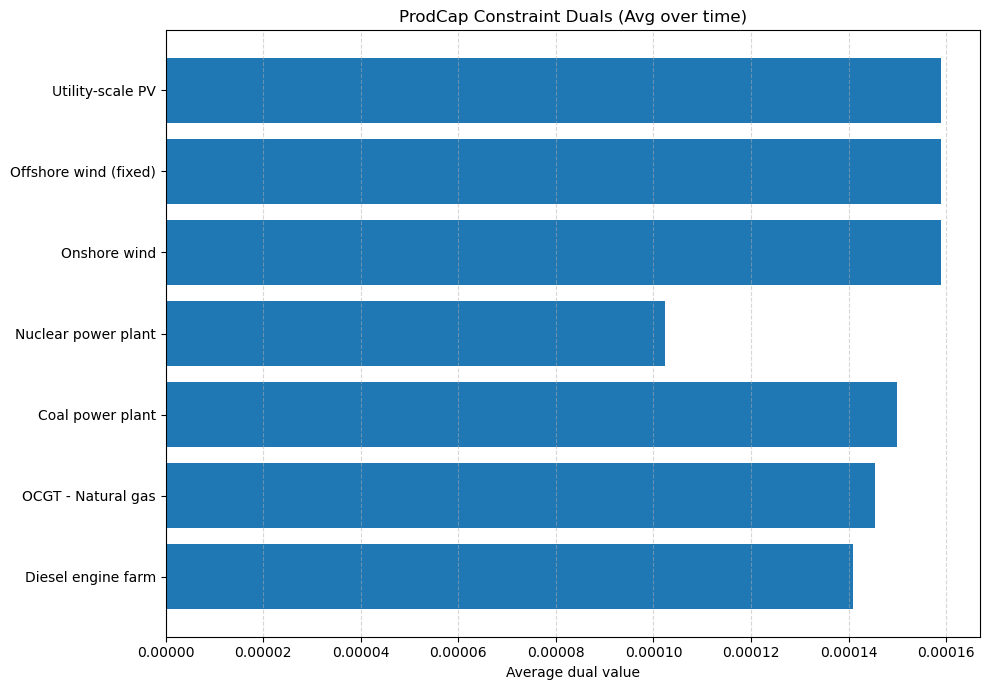

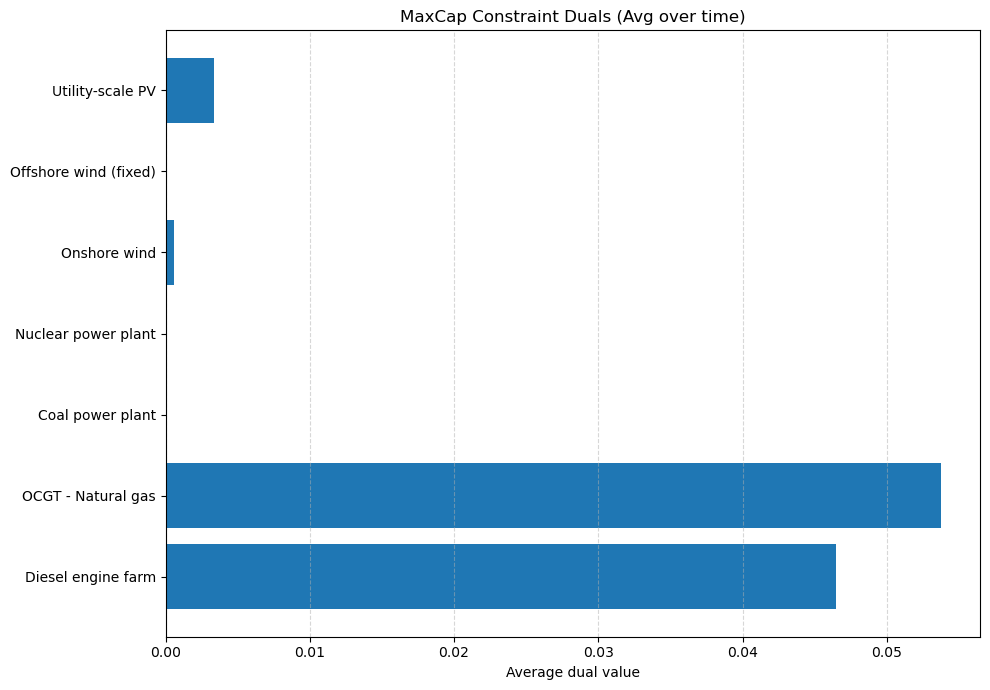

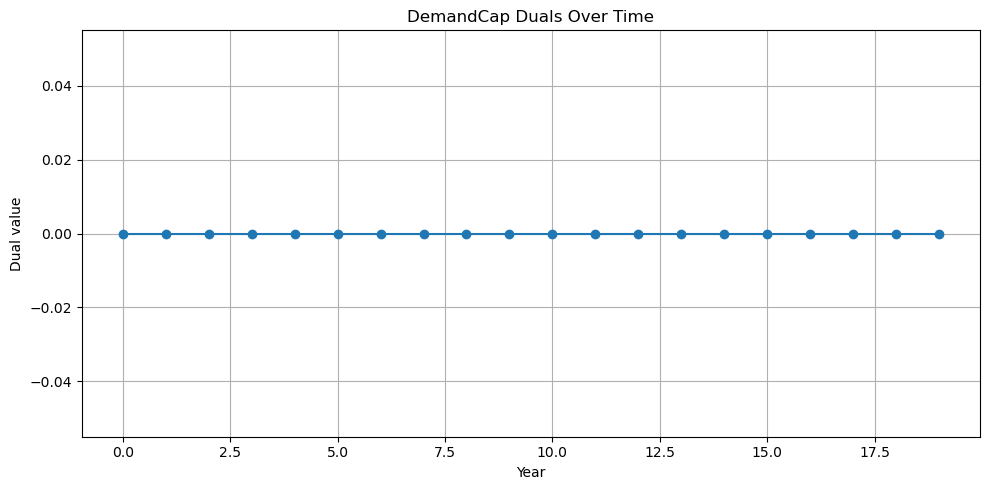

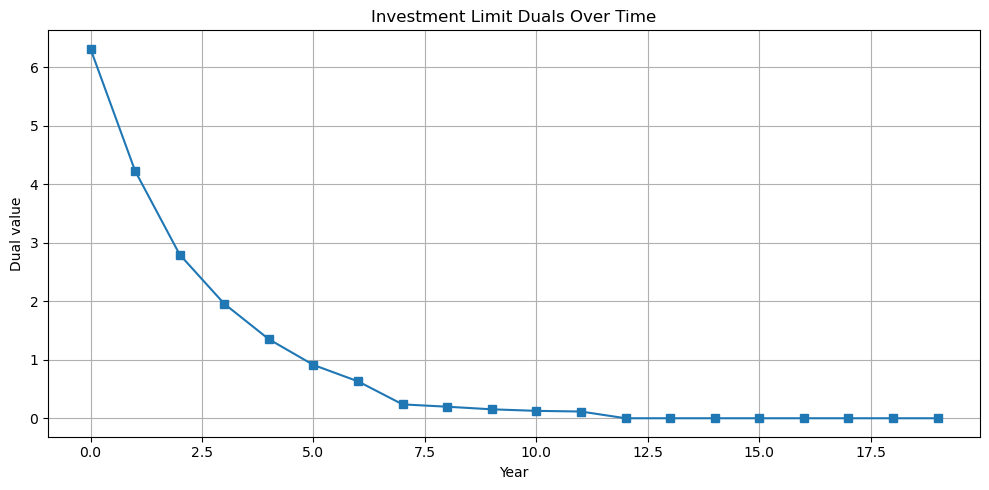

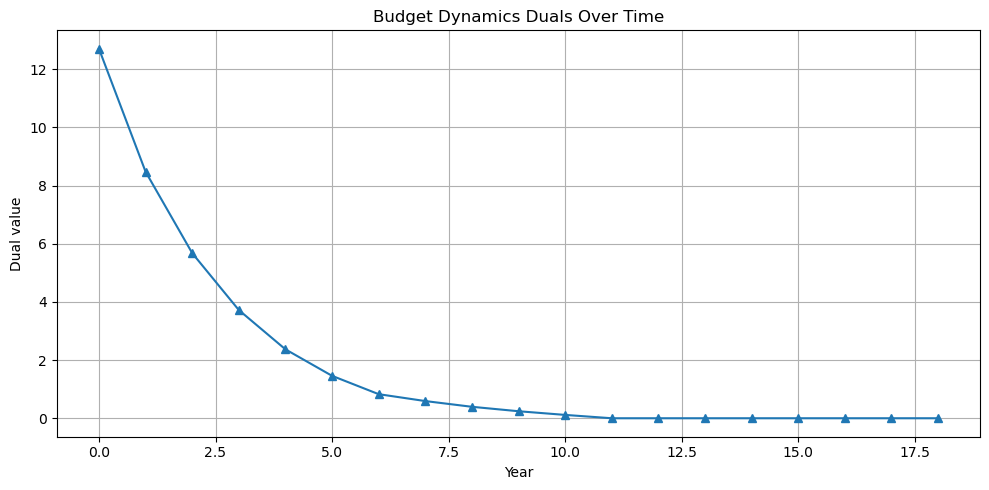


===== DUAL ANALYSIS COMPLETE =====



In [ ]:
# ============================================================
# 3. PLOTS
# ============================================================

# ---------- Plot A: ProdCap duals ----------
plt.figure(figsize=(10,7))
plt.barh(list(avg_prodcap.keys()), list(avg_prodcap.values()))
plt.xlabel("Average dual value")
plt.title("ProdCap Constraint Duals (Avg over time)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ---------- Plot B: MaxCap duals ----------
plt.figure(figsize=(10,7))
plt.barh(list(avg_maxcap.keys()), list(avg_maxcap.values()))
plt.xlabel("Average dual value")
plt.title("MaxCap Constraint Duals (Avg over time)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ---------- Plot C: Demand duals ----------
plt.figure(figsize=(10,5))
plt.plot(time_periods, [demand_duals[t] for t in time_periods], marker='o')
plt.xlabel("Year")
plt.ylabel("Dual value")
plt.title("DemandCap Duals Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# ---------- Plot D: Investment constraint duals ----------
plt.figure(figsize=(10,5))
plt.plot(time_periods, [invlimit_duals[t] for t in time_periods], marker='s')
plt.xlabel("Year")
plt.ylabel("Dual value")
plt.title("Investment Limit Duals Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# ---------- Plot E: Budget dynamics duals ----------
plt.figure(figsize=(10,5))
plt.plot(time_periods[:-1], [budgetdyn_duals[t] for t in time_periods[:-1]], marker='^')
plt.xlabel("Year")
plt.ylabel("Dual value")
plt.title("Budget Dynamics Duals Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


print("\n===== DUAL ANALYSIS COMPLETE =====\n")